# San Francisco Rental Prices Dashboard

In this notebook, you will compile the visualizations from the previous analysis into functions that can be used for a Panel dashboard.

In [15]:
# imports
import panel as pn
pn.extension('plotly')
import plotly.express as px
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
from panel.interact import interact
import os
import math
from pathlib import Path
from dotenv import load_dotenv

In [16]:
# Read the Mapbox API key
load_dotenv()
mapbox_token = os.getenv("MAPBOX_API_KEY")

# Set the Mapbox API
px.set_mapbox_access_token(mapbox_token)

# Import Data

In [17]:
# Import the CSVs to Pandas DataFrames
file_path = Path("Data/sfo_neighborhoods_census_data.csv")
sfo_data = pd.read_csv(file_path, index_col="year")

#file_path = Path("Data/neighborhoods_coordinates.csv")
#df_neighborhood_locations = pd.read_csv(file_path)

- - -

## Panel Visualizations

In this section, you will copy the code for each plot type from your analysis notebook and place it into separate functions that Panel can use to create panes for the dashboard. 

These functions will convert the plot object to a Panel pane.

Be sure to include any DataFrame transformation/manipulation code required along with the plotting code.

Return a Panel pane object from each function that can be used to build the dashboard.

Note: Remove any `.show()` lines from the code. We want to return the plots instead of showing them. The Panel dashboard will then display the plots.

In [18]:
# Define Panel Visualization Functions
def housing_units_per_year():    
    """Housing Units Per Year."""    
    # YOUR CODE HERE!
    mean_Number_housing_units = sfo_data.groupby('year').mean()
    mean_Number_housing_units.drop(columns=[ 'sale_price_sqr_foot', 'gross_rent'], inplace=True)
    x = mean_Number_housing_units.index
    y = mean_Number_housing_units.iloc[:,0]
    low = min(mean_Number_housing_units.iloc[:,0])
    high = max(mean_Number_housing_units.iloc[:,0])
    print(low)
    print( high)
    plt.ylim([math.ceil(low-0.5*(high-low)), math.ceil(high+0.5*(high-low))])
    return plt.bar(x,y)

def average_gross_rent():        
    """Average Gross Rent in San Francisco Per Year."""   
    gross_rent = sfo_data.groupby('year').mean()
    gross_rent.drop(columns=[ 'sale_price_sqr_foot','housing_units'], inplace=True)
    return gross_rent.plot()

def average_sales_price():
    """Average Sales Price Per Year."""
    sale_price_sqr_foot = sfo_data.groupby('year').mean()
    sale_price_sqr_foot.drop(columns=['housing_units', 'gross_rent'], inplace=True)
    return sale_price_sqr_foot.plot()

def average_price_by_neighborhood():
    """Average Prices by Neighborhood."""
    sfo_data1 = pd.read_csv(file_path,index_col='year', infer_datetime_format=True)
    avg_prices_neighborhood = sfo_data1.groupby(['neighborhood','year']).mean().copy()   
    
    def avg_price_per_sqft(neighborhood):
        avg_chart = avg_prices_neighborhood.loc[neighborhood].hvplot(x='year',
                                              y='sale_price_sqr_foot'
                                              )
        return avg_chart

    neighborhoods = sfo_data1.neighborhood.unique()
    return interact(avg_price_per_sqft, neighborhood=neighborhoods)

def create_data_expensive_neighborhoods():                    
    sfo_data1 = pd.read_csv(file_path)
    sfo_data2 = sfo_data1[["neighborhood", "sale_price_sqr_foot", "housing_units", "gross_rent" ]]
    expensive_neighborhood = sfo_data2.groupby(['neighborhood'], as_index=False).mean()
    expensive_neighborhood = expensive_neighborhood.rename(columns ={" " : "avg_sale_price_sqr_foot"})
    expensive_neighborhood_sorted = expensive_neighborhood.sort_values('sale_price_sqr_foot', ascending=False)
    expensive_neighborhood_top10 = expensive_neighborhood_sorted.iloc[0:10, :]
    return expensive_neighborhood_top10

def top_most_expensive_neighborhoods():
    """Top 10 Most Expensive Neighborhoods."""
    expensive_neighborhood_top10 = create_data_expensive_neighborhoods()
    expensive_neighborhood_chart = expensive_neighborhood_top10[["neighborhood", "sale_price_sqr_foot"]]
    expensive_neighborhood_chart = expensive_neighborhood_chart.set_index('neighborhood')
    return expensive_neighborhood_chart.hvplot.bar()

def parallel_coordinates():
    expensive_neighborhood_top10 = create_data_expensive_neighborhoods()
    """Parallel Coordinates Plot."""    
    return px.parallel_coordinates(expensive_neighborhood_top10,
                        dimensions=["neighborhood", "sale_price_sqr_foot", "housing_units", "gross_rent"],
                        color='sale_price_sqr_foot',
                       color_continuous_scale=px.colors.sequential.Inferno
                       )

def parallel_categories():
    expensive_neighborhood_top10 = create_data_expensive_neighborhoods()
    """Parallel Categories Plot."""
    return px.parallel_categories(
        expensive_neighborhood_top10,
        dimensions=["neighborhood", "sale_price_sqr_foot", "housing_units", "gross_rent"],
        color= "sale_price_sqr_foot",
        color_continuous_scale=px.colors.sequential.Inferno
    )
def create_scattermap_data():
    #file_path = Path("Data/sfo_neighborhoods_census_data.csv")
    sfo_data1 = pd.read_csv(file_path)
    sfo_data2 = sfo_data1[["neighborhood", "sale_price_sqr_foot", "housing_units", "gross_rent" ]]
    expensive_neighborhood = sfo_data2.groupby(['neighborhood'], as_index=False).mean()
    
    file_path_c = Path("Data/neighborhoods_coordinates.csv")
    df_neighborhood_locations = pd.read_csv(file_path_c)
    
    avg_value_wlocation = pd.concat(
        [expensive_neighborhood, df_neighborhood_locations], axis="columns", join="inner"
    )
    avg_value_wlocation.drop(columns=['neighborhood'], inplace=True)
    return avg_value_wlocation

def neighborhood_map():
    """Neighborhood Map"""
    avg_value_wlocation = create_scattermap_data()        
    neighborhood_map = px.scatter_mapbox(
        avg_value_wlocation,
        lat="Lat",
        lon="Lon",
        size="sale_price_sqr_foot",
        color="gross_rent"
    )
    return neighborhood_map    


## Panel Dashboard

In this section, you will combine all of the plots into a single dashboard view using Panel. Be creative with your dashboard design!

372560
384242


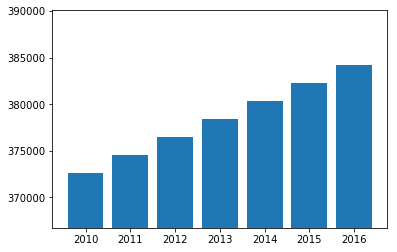

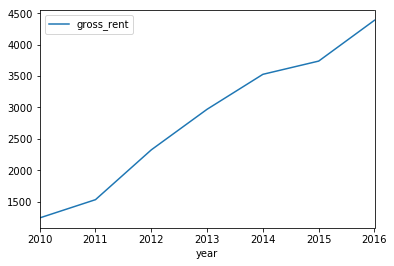

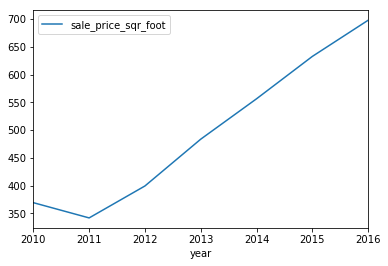

In [19]:
# YOUR CODE HERE!

column_avg = pn.Column(
    '# Average costs', 
    housing_units_per_year(), 
    average_gross_rent(), 
    average_sales_price()
)
column_neigbhorhood = pn.Column(
    '# Neigbhorhood costs', 
    average_price_by_neighborhood(), 
    top_most_expensive_neighborhoods()
)
column_parallel = pn.Column(
    '# Parallel Plots', 
    parallel_coordinates(), 
    parallel_categories()
)
column_map = pn.Column(
    '# Neigbhorhood Map Plots', 
    neighborhood_map()
)

tabs = pn.Tabs(
    ("Cost of Living in SFO area", column_avg),
    ("Expensive neigbhorhoods in SFO area", column_neigbhorhood),
    ("Parallel visualizations of neigbhorhoods in SFO area", column_parallel),
    ("Scatter Map of  rent and sales price per sqft of neigbhorhoods in SFO area", column_map)
)

## Serve the Panel Dashboard

In [14]:
tabs.servable()

Tabs
    [0] Column
        [0] Markdown(str)
        [1] Str(BarContainer)
        [2] Str(AxesSubplot)
        [3] Str(AxesSubplot)
    [1] Column
        [0] Markdown(str)
        [1] Column
            [0] Column
                [0] Select(name='neighborhood', options=['Alamo Square', ...], value='Alamo Square')
            [1] Row
                [0] HoloViews(Curve, name='interactive02630')
        [2] HoloViews(Bars)
    [2] Column
        [0] Markdown(str)
        [1] Plotly(Figure)
        [2] Plotly(Figure)
    [3] Column
        [0] Markdown(str)
        [1] Plotly(Figure)